In [1]:
from gerrychain import Graph

In [2]:
#read the iowa json county graph
filepath = 'C:\\district-data\\'
filename = 'COUNTY_19.json'
G = Graph.from_json( filepath + filename )

In [3]:
#Make sure the file is read correctly by printing the node #, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    x_coordinate = G.nodes[node]['C_X']
    y_coordinate = G.nodes[node]['C_Y']
    print("Node",node,"is",name,"County, which has population on",population,"and is centered at (",x_coordinate,",",y_coordinate,")")

Node 0 is Marshall County, which has population on 40648 and is centered at ( -92.99877061994405 , 42.03584991494549 )
Node 1 is Benton County, which has population on 26076 and is centered at ( -92.0656911571341 , 42.08018636134706 )
Node 2 is Clay County, which has population on 16667 and is centered at ( -95.15091942826078 , 43.08258040539963 )
Node 3 is Shelby County, which has population on 12167 and is centered at ( -95.31021132757591 , 41.6850926048501 )
Node 4 is Clayton County, which has population on 18129 and is centered at ( -91.34143277875053 , 42.84474932363271 )
Node 5 is Jackson County, which has population on 19848 and is centered at ( -90.57422946144632 , 42.17174262526901 )
Node 6 is Hamilton County, which has population on 15673 and is centered at ( -93.7068082697318 , 42.38377217191507 )
Node 7 is Taylor County, which has population on 6317 and is centered at ( -94.6964147813078 , 40.73743235848062 )
Node 8 is Muscatine County, which has population on 42745 and is 

In [4]:
#create distance dictionary
from geopy.distance import geodesic

Marshal = ( G.nodes[0]['C_Y'], G.nodes[0]['C_X'] )
Boone = ( G.nodes[52]['C_Y'], G.nodes[52]['C_X'] )
Polk = ( G.nodes[73]['C_Y'], G.nodes[73]['C_X'] )

print("Marshal -> Boone",geodesic(Marshal, Boone).miles)
print("Boone -> Polk", geodesic(Boone, Polk).miles)
print("Polk -> Marshal",geodesic(Polk, Marshal).miles)

Marshal -> Boone 47.999270588407306
Boone -> Polk 30.46950404315813
Polk -> Marshal 38.2620518877553


In [5]:
#Check the dictionary 
dist = dict()
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [6]:
print("Marshal -> Boone:",dist[0,52])

Marshal -> Boone: 47.999270588407306


In [7]:
#Find the upper and lower bound 
deviation = 0.01

import math 
K = 4
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/K)
U = math.floor((1+deviation/2)*total_population/K)
print("Using L =",L,"and U =",U,"and K =",K)

Using L = 757781 and U = 765396 and K = 4


In [8]:
#Start of the model
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()
#X[i,j] variable which equals one when county i 
#       Is assigned to (the district centered at) county j
X = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

Academic license - for non-commercial use only - expires 2021-06-25
Using license file C:\Users\jared\gurobi.lic


In [9]:
#Objective equation
m.setObjective( gp.quicksum( dist[i,j]*dist[i,j]*G.nodes[i]['TOTPOP']*X[i,j] for i in G.nodes for j in G.nodes), GRB.MINIMIZE )

In [10]:
#Constraint equations
#each county i is assigned to one district
m.addConstrs( gp.quicksum(X[i,j] for j in G.nodes) == 1 for i in G.nodes) 
#there should be K 
m.addConstr( gp.quicksum( X[j,j] for j in G.nodes ) == K )
#the population in each district has to be bwtween the upper and lower limits
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * X[i,j] for i in G.nodes) >= L * X[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * X[i,j] for i in G.nodes) <= U * X[j,j] for j in G.nodes )
#if i is assigned to j then j is center
m.addConstrs( X[i,j] <= X[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [11]:
#Add the contiguity by adding mpre constraints
import networkx as nx 
DG = nx.DiGraph(G)
#Define new variables 
f = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes()-1
#node j cannot recieve flow of its own type
m.addConstrs( gp.quicksum( f[j,u,j] for u in DG.neighbors(j) ) == 0 for j in DG.nodes )
#node i can recieve flow of type j only if i is assigned to j
m.addConstrs( gp.quicksum( f[j,u,i] for u in DG.neighbors(i)) <= M * X[i,j] for i in DG.nodes for j in DG.nodes if i != j )
#i is assigned to j, then i should consume one unit of j flow 
#     Otherwise,, i should consume no units 
m.addConstrs( gp.quicksum( f[j,u,i] - f[j,i,u] for u in DG.neighbors(i)) == X[i,j] for i in DG.nodes for j in DG.nodes if i != j )

m.update()

In [12]:
#optimize
m.Params.MIPGap = 0.0
m.optimize()

Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 29602 rows, 53757 columns and 199290 nonzeros
Model fingerprint: 0xc9f1a4ba
Variable types: 43956 continuous, 9801 integer (9801 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [2e+06, 2e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 203 rows and 444 columns
Presolve time: 1.43s
Presolved: 29399 rows, 53313 columns, 198395 nonzeros
Variable types: 43512 continuous, 9801 integer (9801 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objecti

In [13]:
#Print what counties are in each district
print("The moment of inertia objective is",m.objval)

centers = [j for j in G.nodes if X[j,j].x > 0.5 ]
districts = [ [i for i in G.nodes if X[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(K)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(K) ]
for j in range(K):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The moment of inertia objective is 6851641139.809169
District 0 has population 763144 and contains counties ['Jackson', 'Muscatine', 'Clinton', 'Iowa', 'Washington', 'Johnson', 'Monroe', 'Dubuque', 'Van Buren', 'Jefferson', 'Davis', 'Scott', 'Cedar', 'Des Moines', 'Henry', 'Jones', 'Louisa', 'Wapello', 'Lee']
District 1 has population 758120 and contains counties ['Clay', 'Shelby', 'Wright', 'Buena Vista', 'Woodbury', 'Kossuth', 'Sac', 'Humboldt', 'Cherokee', 'Lyon', "O'Brien", 'Guthrie', 'Dickinson', 'Plymouth', 'Dallas', 'Palo Alto', 'Fremont', 'Montgomery', 'Webster', 'Calhoun', 'Boone', 'Page', 'Ida', 'Crawford', 'Carroll', 'Audubon', 'Sioux', 'Adair', 'Mills', 'Monona', 'Harrison', 'Emmet', 'Cass', 'Osceola', 'Hancock', 'Pocahontas', 'Greene', 'Pottawattamie']
District 2 has population 760858 and contains counties ['Marshall', 'Benton', 'Clayton', 'Worth', 'Winnebago', 'Keokuk', 'Franklin', 'Floyd', 'Black Hawk', 'Mitchell', 'Butler', 'Linn', 'Delaware', 'Hardin', 'Buchanan', 'Chi

In [14]:
#Start creation of the map
import geopandas as gpd

In [15]:
#Find files in computer to graph iowa
filepath_ = 'C:\\district-data\\'
filename_ = 'IA_counties.shp'

df = gpd.read_file( filepath_ + filename_ )

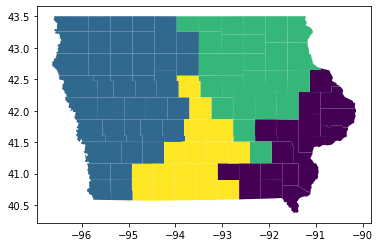

In [16]:
#Finish maps
assignment = [ -1 for u in G.nodes ]

for j in range(len(districts)):
    
    for i in districts[j]:
    
        geoID = G.nodes[i]["GEOID10"]
    
        for u in G.nodes:
            if geoID == df["GEOID10"][u]:
                assignment[u] = j
        
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()